In [1]:
import numpy as np
from random import shuffle
import matplotlib.pyplot as plt
from data_process import load_CIFAR10
# Load the raw CIFAR-10 data.
cifar10_dir = '/Users/vuhoangnguyen/cifar-10-batches-py'
X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)

# As a sanity check, we print out the size of the training and test data.
print('Training data shape: ', X_train.shape)
print('Training labels shape: ', y_train.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)

Training data shape:  (50000, 32, 32, 3)
Training labels shape:  (50000,)
Test data shape:  (10000, 32, 32, 3)
Test labels shape:  (10000,)
Training data shape:  (50000, 32, 32, 3)
Training labels shape:  (50000,)
Test data shape:  (10000, 32, 32, 3)
Test labels shape:  (10000,)


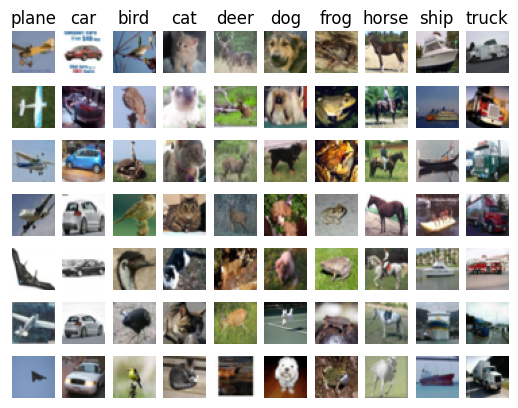

In [2]:
# Visualize some examples from the dataset.
# We show a few examples of training images from each class.
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
num_classes = len(classes)
samples_per_class = 7
for y, cls in enumerate(classes):
    idxs = np.flatnonzero(y_train == y) # return the indices of elements that are non-zero
    idxs = np.random.choice(idxs, samples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt_idx = i * num_classes + y + 1
        plt.subplot(samples_per_class, num_classes, plt_idx)
        plt.imshow(X_train[idx].astype('uint8'))
        plt.axis('off')
        if i == 0:
            plt.title(cls)
plt.show()

In [3]:
# Split the data into train, val, and test sets. In addition we will
# create a small development set as a subset of the training data;
# we can use this for development so our code runs faster.
num_training = 49000
num_validation = 1000
num_test = 1000
num_dev = 500

# Our validation set will be num_validation points from the original training set.
mask = range(num_training, num_training + num_validation)
X_val = X_train[mask]
y_val = y_train[mask]

# Our training set will be the first num_train points from the original training set.
mask = range(num_training)
X_train = X_train[mask]
y_train = y_train[mask]

# We will also make a development set, which is a small subset of the training set.
mask = np.random.choice(num_training, num_dev, replace=False)
X_dev = X_train[mask]
y_dev = y_train[mask]

# We use the first num_test points of the original test set as our test set.
mask = range(num_test)
X_test = X_test[mask]
y_test = y_test[mask]

print('Train data shape: ', X_train.shape)
print('Train labels shape: ', y_train.shape)
print('Validation data shape: ', X_val.shape)
print('Validation labels shape: ', y_val.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)

Train data shape:  (49000, 32, 32, 3)
Train labels shape:  (49000,)
Validation data shape:  (1000, 32, 32, 3)
Validation labels shape:  (1000,)
Test data shape:  (1000, 32, 32, 3)
Test labels shape:  (1000,)


In [4]:
# Preprocessing: reshape the image data into rows
X_train = np.reshape(X_train, (X_train.shape[0], -1))
X_val = np.reshape(X_val, (X_val.shape[0], -1))
X_test = np.reshape(X_test, (X_test.shape[0], -1))
X_dev = np.reshape(X_dev, (X_dev.shape[0], -1))

print('Training data shape: ', X_train.shape)
print('Validation data shape: ', X_val.shape)
print('Test data shape: ', X_test.shape)
print('Dev data shape: ', X_dev.shape)

Training data shape:  (49000, 3072)
Validation data shape:  (1000, 3072)
Test data shape:  (1000, 3072)
Dev data shape:  (500, 3072)


(3072,)


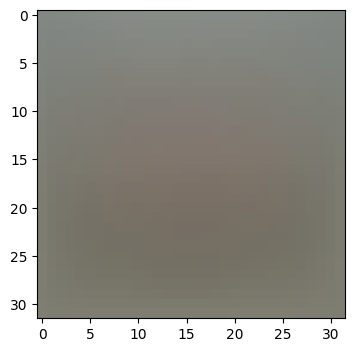

In [5]:
# Preprocessing: subtract the mean image
# Step 1: compute the image mean based on the training data
mean_image = np.mean(X_train, axis=0)
print(mean_image.shape)
plt.figure(figsize=(4,4))
plt.imshow(mean_image.reshape((32,32,3)).astype('uint8')) # visualize the mean image
plt.show()

In [6]:
# Step 2: subtract the mean image from train and test data
X_train -= mean_image
X_val -= mean_image
X_test -= mean_image
X_dev -= mean_image

In [7]:
# Step 3: add bias 
X_train = np.concatenate((X_train, np.ones((X_train.shape[0],1))),axis = 1)
X_val = np.concatenate((X_val, np.ones((X_val.shape[0],1))),axis = 1)
X_test = np.concatenate((X_test, np.ones((X_test.shape[0],1))),axis = 1)
X_dev = np.concatenate((X_dev, np.ones((X_dev.shape[0],1))),axis = 1)

Total loss formula:
$L(X,y,W) = \frac{1}{N} \sum_{n=1}^N \sum_{j \neq y_n} max(0, 1 - w^T_{y_n} x_n + w^T_{j} x_n) + \frac{reg}{2} ||W||^2 $

In [24]:
from MulSVM import multi_svm_GD, predict

learning_rates = [1e-7, 2e-7, 3e-7, 8e-7]
regularization = [1e4, 2e4, 3e4, 4e4, 5e4, 6e4, 7e4, 8e4, 1e5]
best_val = -1
best_para = None
for lr in learning_rates:
    for reg in regularization:
        Winit = np.random.randn(X_train.shape[1],num_classes) * 0.0001
        W, loss_history = multi_svm_GD(X_train.T, y_train, Winit, reg=reg, num_iters=2000, print_every=1000)
        y_train_pred = predict(X_train, W)
        y_val_pred = predict(X_val, W)
        train_acc = np.mean(y_train_pred == y_train)
        val_acc = np.mean(y_val_pred == y_val)
        print('lr: ', lr, 'reg: ', reg, 'train:', train_acc, 'val:', val_acc)
        if val_acc > best_val:
            best_val = val_acc
            best_para = (W, lr, reg)

y_test_pred = predict(X_test, best_para[0])
test_acc = np.mean(y_test_pred == y_test)
print('best_val: ', best_val, 'best_para: ', best_para[1:], 'test_acc: ', test_acc)

iter 1/2000, loss = 9.286090836958167
iter 1001/2000, loss = 5.777543101999905
lr:  1e-07 reg:  10000.0 train: 0.38273469387755105 val: 0.376
iter 1/2000, loss = 11.01459642022126
iter 1001/2000, loss = 4.91942037280657
lr:  1e-07 reg:  20000.0 train: 0.37281632653061225 val: 0.375
iter 1/2000, loss = 13.246267953292028
iter 1001/2000, loss = 4.840306716048549
lr:  1e-07 reg:  30000.0 train: 0.3763061224489796 val: 0.384
iter 1/2000, loss = 13.781814013632285
iter 1001/2000, loss = 5.062545411537617
lr:  1e-07 reg:  40000.0 train: 0.3673877551020408 val: 0.358
iter 1/2000, loss = 16.115741739743427
iter 1001/2000, loss = 5.8627928426882265
lr:  1e-07 reg:  50000.0 train: 0.36428571428571427 val: 0.369
iter 1/2000, loss = 17.41499721083902
iter 1001/2000, loss = 5.516136272144806
lr:  1e-07 reg:  60000.0 train: 0.35953061224489796 val: 0.366
iter 1/2000, loss = 18.95144833039263
iter 1001/2000, loss = 5.870680937284403
lr:  1e-07 reg:  70000.0 train: 0.35889795918367345 val: 0.365
iter 